# BI8040-Logical Modeling for Experimental Design in Biotechnology and Biomedicine, NTNU

## Corinna Dannert & Yitong Sun
### August, 2020

## Apoptosis and Cell Fate Model

The mechanisms by which a cell chooses whether it will start apoptosis, necrosis (or other non-apoptotic cell deaths) or whether it will continue surviving are still unclear. Therefore, a logical model simulating the regulatory network controlling the cell-fate can help increase the understanding of these mechanisms. 

In this project, we analyzed the model designed by Calzone, L. et al. (2010). Mathematical Modelling of Cell-Fate Decision in Response to Death Receptor Engagement. Plos computational biology. doi:10.1371/journal.pcbi.1000702

This project aims to (1)obtain knowledge about reproducible results under the same docker environment and (2)perform logical modeling analysis enabled by various software tools.

For the reproducible purpose, given that Docker and Python are installed, this notebook can be executed using the command line:
```
colomoto-docker -V 2020-08-01
```

For the model analysis part, all the software tools used in this notebook are listed in *Table 1*.

**Table 1** List of software tools used in this notebook

_|Tool   |Website |  Feature executed
:----     |:------ | :----------------------------- | :------------------------------------------------------------
1|GINsim | [ginsim.org](http://ginsim.org) | Model import and visualization, conversion to bioLQM and Pint
2|bioLQM | [colomoto.org/biolqm](http://colomoto.org/biolqm) | Trapspaces and fixpoint computation, conversion to MaBoSS
3|Pint   | [loicpauleve.name/pint](http://loicpauleve.name/pint) | Transient reachability analysis, mutation prediction, conversion to NuSMV
4|NuSMV  | [nusmv.fbk.eu](http://nusmv.fbk.eu) | Phenotype reachability checking
5|MaBoSS | [maboss.curie.fr](https://maboss.curie.fr) | Stochastic simulations, reachability analysis of certain phenotypes under different mutations


### Our workflow can be described as below and shown in the figure`Out[1]`, tool-centric manner

**On the master model:**

       (1) Importing and visualization of the GINsim model
       (2) Trapspaces and fixpoint computation, perturbation analysis using BioLQM.
       (3) Model checking with NuSMV.
       (4) Goal reachability analysis, mutation prediction with Pint.
       (5) Stochastic simulations, reachability analysis using MaBoSS.

**On the reduced model:**

       (1) GINsim model reduction, attractor analysis.
       (2) MaBoSS simulations on wild-type model.

In [1]:
from IPython.display import Image
Image(url = "https://raw.githubusercontent.com/yitong-sun/BI8040_2020/master/workflow.jpg")

# Highlight  --- Content you can find in this project, stepwise order

### Master model:

#### Wild-type model
    - GINsim, model loading and visualization
    - bioLQM, attractor analysis
    - Pint,   reachability analysis  (TNF=0,FAS=0)&(TNF=1,FAS=0)
    - NuSMV,  model checking         (TNF=0,FAS=0)&(TNF=1,FAS=0)
    - MaBoSS, stochastic simulation  (TNF=0,FAS=0)&(TNF=1,FAS=0)
    (The above three all get the same results when using different tools)

#### Single mutations perturbation, reproduce from paper
    - bioLQM, results displayed on the heatmap
    - MaBoSS, results shown in pie charts and trajectory plots

#### Double mutation prediction, new insight explored
    - Pint, formal mutation prediction (oneshot_mutations_for_cut)&(cutsets)
    - MaBoSS, confirm simulation result above


### Reduced model:

#### Wild-type model
    - Attractor analysis
    - MaBoSS reachability analysis,
      same as that of the master model, which is indicated in the paper.

## Modules Importing and Model Loading

In [2]:
import ginsim
import biolqm
import maboss
import sys
import pypint
import pandas as pd
import seaborn as sns
from pypint import Goal
from colomoto.temporal_logics import *
from colomoto_jupyter import tabulate # for results table display
from itertools import combinations  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
plt.rcParams.update({'figure.max_open_warning': 0}) # supress warnings when plotting too many piecharts

This notebook has been executed using the docker image `colomoto/colomoto-docker:2020-08-01`

In [3]:
# Loading the apoptosis model from Calzone et al.
model_ginsim=ginsim.load("http://ginsim.org/sites/default/files/Calzone__Cell_Fate.zginml")
ginsim.show(model_ginsim)

Downloading http://ginsim.org/sites/default/files/Calzone__Cell_Fate.zginml

The model is online available at GINsim model repository: 
[http://ginsim.org/models_repository](http://ginsim.org/models_repository).

In this regulatory network, three input nodes trigger the death receptor signals, and three output nodes correspondents to three cross-talk pathways namely "NFkB pro-survival pathway"---`Survival`, "RIP1-dependent necrosis"---`NonACD`, "Caspase-dependent apoptosis"---`Apoptosis`. Edges are annotated with Boolean formalism, presenting here red as inhibition and green for activation.

## Model Conversion Summay

In [4]:
# Converting the model to biolqm, maboss, pint and nusmv for further analysis

model_biolqm = ginsim.to_biolqm(model_ginsim) # convert to biolqm
model_maboss = biolqm.to_maboss(model_biolqm) # convert to maboss
model_pint = ginsim.to_pint(model_ginsim) # convert to pint
model_nusmv= model_pint.to_nusmv() # convert to nusmv

## Computation of Stable States using bioLQM

First, we performed the trapsapces analysis to identify the attractors. 


The result shows 27 trapspaces (stable motifs), each row is associated with one phenotype as survival(`Survival`=1), apoptosis(`Apoptosis`=1), necrosis(`NonACD`=1), and when none of the output nodes equal to value 1, the cells stay in ‘‘naive’’ state.

In [5]:
# Trapspaces analysis with the wild-type model
traps = biolqm.trapspace(model_biolqm)
tabulate(traps)

,FASL,TNF,TNFR,DISC_TNF,DISC_FAS,FADD,RIP1,RIP1ub,RIP1K,IKK,NFkB,CASP8,BAX,BCL2,ROS,ATP,MPT,MOMP,SMAC,cIAP,Cyt_c,XIAP,apoptosome,CASP3,cFLIP,NonACD,Apoptosis,Survival
18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0
17,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0
6,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0
3,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0
24,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0


Then stable states (fixpoints) are computed and displayed in table format. We have 27 fixpoints calculated as the same in the paper. Worth mentioning is that the same result from trapspaces and fixpoints analysis indicates that no cyclical attractor is found in our model.

In [6]:
fps = biolqm.fixpoints(model_biolqm) # calculate fixpoints
print(len(fps), "fixpoints") # shows the number of fixpoints
tabulate(fps) # table displaying all the fixpoints

27 fixpoints


,FASL,TNF,TNFR,DISC_TNF,DISC_FAS,FADD,RIP1,RIP1ub,RIP1K,IKK,NFkB,CASP8,BAX,BCL2,ROS,ATP,MPT,MOMP,SMAC,cIAP,Cyt_c,XIAP,apoptosome,CASP3,cFLIP,NonACD,Apoptosis,Survival
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0
7,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0
8,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0
9,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0


The fixed points can be visualized and here we show the number 11 fixpoint for example.

In [7]:
ginsim.show(model_ginsim, fps[11]) #show specific fixpoint (here number 11)

# Assessment of Reachability using Pint

After the computation of attractors, we would like to test the reachability of attractors to a goal state, which means it can be  `Survival`, `NonACD`, or `Apoptosis`. 

For this wild-type model, we performed the analysis under two initial conditions:
```
(1)TNF=1 and FAS=0, leading to ALL TRUE in three states that possible to reach.
(2)TNF=0 and FAS=0, leading to ALL FALSE so that cells stay at naive state.
```

With the "physiological" initial condition settings used, that is, intermediate nodes cIAP=1, ATP=1; and FADD always ON as it is throughout this project.

The initial states can also be set directly in the reachability analysis. This analysis shows us whether we can reach our desired output by returning "True" or "False".

In [8]:
# Assess the reachability of a goal using pint (transient reachability analysis)
Survival= Goal("Survival=1")
Apoptosis = Goal("Apoptosis=1")
NonACD = Goal("NonACD=1")

goals=["Survival", "Apoptosis", "NonACD"]
model_pint_list={}


# For the inital condition: TNF=1 and FAS=0
print(model_pint.having({"TNF": 1, "FASL": 0, "FADD": 1, "ATP": 1, "cIAP": 1}).reachability("Survival=1"))

print(model_pint.having({"TNF": 1, "FASL": 0, "FADD": 1, "ATP": 1, "cIAP": 1}).reachability("Apoptosis=1"))

print(model_pint.having({"TNF": 1, "FASL": 0, "FADD": 1, "ATP": 1, "cIAP": 1}).reachability("NonACD=1"))


# For the initial condition: TNF=0 and FAS=0
print(model_pint.having({"TNF": 0, "FASL": 0, "FADD": 1, "ATP": 1, "cIAP": 1}).reachability("Survival=1"))

print(model_pint.having({"TNF": 0, "FASL": 0, "FADD": 1, "ATP": 1, "cIAP": 1}).reachability("Apoptosis=1"))

print(model_pint.having({"TNF": 0, "FASL": 0, "FADD": 1, "ATP": 1, "cIAP": 1}).reachability("NonACD=1"))


True
True
True
False
False
False


Then, we reproduce the same results using NuSMV model checking function.

# Model Checking using NuSMV

Here we also start from the initial conditions:
```
(1)TNF=1 and FAS=0
(2)TNF=0 and FAS=0
```  
getting the same results as `Out [9]` in the output below. When (1)TNF is ON and FAS is OFF, all three phenotypes can be reached, while (2)both TNF and FAS are both OFF, none phenotype can be reached thus end at the naive state.

In [9]:
#from colomoto.temporal_logics import *
# intial state with TNF=1, FAS=0. 

initial_state = S(FASL=0,FADD=1,TNF=1,TNFR=0,DISC_TNF=0,DISC_FAS=0,RIP1=0,RIP1ub=0,RIP1K=0,IKK=0,NFkB=0,CASP8=0,BAX=0,BCL2=0,ROS=0,ATP=1,MPT=0,MOMP=0,SMAC=0,cIAP=1,Cyt_c=0,XIAP=0,apoptosome=0,CASP3=0,cFLIP=0,NonACD=0,Apoptosis=0,Survival=0)

survival = AG(S(Survival=1,FADD=1))
nonACD = AG(S(NonACD=1,FADD=1))
apoptosis = AG(S(Apoptosis=1,FADD=1))
# add multiple stable states
specs = {
    "reach_survival": If(initial_state,EF(survival)),
    "reach_nonacd": If(initial_state,EF(nonACD)),
    "reach_apoptosis": If(initial_state,EF(apoptosis))
}

model_nusmv.add_ctls(specs)
model_nusmv.verify()

{'reach_survival': True, 'reach_nonacd': True, 'reach_apoptosis': True}

In [10]:
# initial condition TNF=0, FAS=0

model_nusmv= model_pint.to_nusmv() # convert to nusmv

initial_state = S(FASL=0,FADD=1,TNF=0,TNFR=0,DISC_TNF=0,DISC_FAS=0,RIP1=0,RIP1ub=0,RIP1K=0,IKK=0,NFkB=0,CASP8=0,BAX=0,BCL2=0,ROS=0,ATP=1,MPT=0,MOMP=0,SMAC=0,cIAP=1,Cyt_c=0,XIAP=0,apoptosome=0,CASP3=0,cFLIP=0,NonACD=0,Apoptosis=0,Survival=0)
#initial_state = S(FASL=0,FADD=1,TNF=1,ATP=1,cIAP=1) #define the initial states
survival = AG(S(Survival=1,FADD=1))
nonACD = AG(S(NonACD=1,FADD=1))
apoptosis = AG(S(Apoptosis=1,FADD=1))
# add multiple stable states
specs = {
    "reach_survival": If(initial_state,EF(survival)),
    "reach_nonacd": If(initial_state,EF(nonACD)),
    "reach_apoptosis": If(initial_state,EF(apoptosis))
}

model_nusmv.add_ctls(specs)
model_nusmv.verify()

{'reach_survival': False, 'reach_nonacd': False, 'reach_apoptosis': False}

Next, we confirm the results from the wild-type model with reachability analysis ran in MaBoSS. 

# Assessment of Reachability using MaBoSS

## Initial States
Here we will calculate whether the stable states `Survival`, `NonACD`, and `Apoptosis` can be reached when starting from a specific set of initial states using the MaBoSS formalism. 

We focus on TNF and FAS proteins since they can trigger cell death. 

Therefore, we start by setting the initial states for MaBoSS simulation.

First, the initial states have to be chosen. Then through a random Markov process, the system can be simulated and its trajectories can be analyzed. 

In [11]:
model_maboss.update_parameters(discrete_time=0, use_physrandgen=0,
        seed_pseudorandom=100, sample_count=10000,
        max_time=75, time_tick=0.1, thread_count=4,
        statdist_traj_count=100, statdist_cluster_threshold=0.9)

Choosing the output nodes, here `Survival`, `NonACD` and `Apoptosis`.


In [12]:
#maboss.wg_set_output(model_maboss)
#maboss.set_output(model_maboss, ["NonACD","Survival", "Apoptosis"])
model_maboss.network.set_output(('Apoptosis','Survival','NonACD'))

## MaBoSS simulation of the wild-type model

The object model_maboss represents the input of MaBoSS, encompassing both the network and simulation parameters. The simulations are triggered with the .run() method and return a Python object for accessing the results.

Here we have the result as ALL phenotypes can be reached at initial state TNF=1 and FAS=0 in ```Out[13]```, which comply with that ALL TRUE results from Pint and NuSMV.

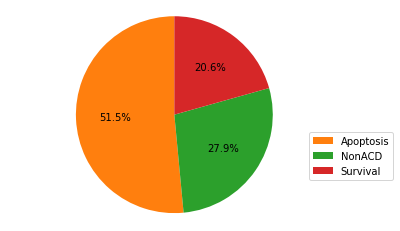

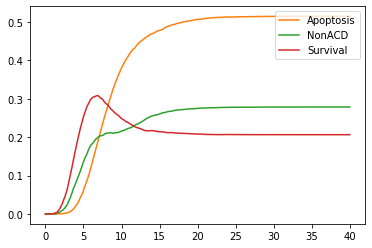

In [13]:
# initial state TNF=1 and FAS=0
maboss_2 = model_maboss.copy()
maboss_2.network.set_istate('TNF', [0,1])
maboss_2.network.set_istate('FASL', [1,0])
maboss.set_nodes_istate(maboss_2, ["ATP", "cIAP", "FADD"], [0,1])
#print(maboss_2.get_initial_state())

# Perform the simulation
result = maboss_2.run()
result.plot_piechart()
result.plot_node_trajectory(until=40)

Then, at initial state TNF=FAS=0, with ALL FALSE results from previous analysis using Pint and NuSMV, below we get the pie chart as null because none of the three cell fate can be reached. 

{'FASL': 0, 'TNF': 0, 'TNFR': 0, 'DISC_TNF': 0, 'DISC_FAS': 0, 'FADD': 1, 'RIP1': 0, 'RIP1ub': 0, 'RIP1K': 0, 'IKK': 0, 'NFkB': 0, 'CASP8': 0, 'BAX': 0, 'BCL2': 0, 'ROS': 0, 'ATP': 1, 'MPT': 0, 'MOMP': 0, 'SMAC': 0, 'cIAP': 1, 'Cyt_c': 0, 'XIAP': 0, 'apoptosome': 0, 'CASP3': 0, 'cFLIP': 0, 'NonACD': 0, 'Apoptosis': 0, 'Survival': 0}


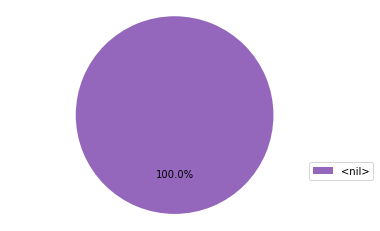

In [14]:
##initial state TNF=FAS=0
maboss_1 = model_maboss.copy()
maboss.set_nodes_istate(maboss_1, ["ATP", "cIAP", "FADD"], [0,1])
maboss.set_nodes_istate(maboss_1, ["TNF", "FASL"], [1,0])

print(maboss_1.get_initial_state())

# Perform the simulation
result = maboss_1.run()
result.plot_piechart()
#result.plot_node_trajectory(until=40)

Until now, we verified the analysis results of the wild-type model at two set of initial conditions:
```
(1)TNF=1 and FAS=0
(2)TNF=0 and FAS=0
```  
using three different software tools in CoLoMoTo notebook, namely Pint, NuSMV, and MaBoSS.

When TNF is turned on in the initial state, all three final states can be reached and the trajectories can be plotted, while the naive state has no data to plot a cell fate trajectory so only the pie chart is shown.

The resulting object gives access to the output data generated by MaBoSS. It includes notably the mean probability overtime for the activity of the output states integrated over all the performed simulations.

# Single mutations perturbation, reproduce from paper

## bioLQM with heatmap display

The single mutation perturbation analysis using bioLQM shows all reachable stable states of the master model. Under the condition that each node knock-down (OFF) or over-expression (ON).

We ran all the perturbations under the mutated conditions specified in the paper. The results are shown the heatmap with all reachable stable states displayed.

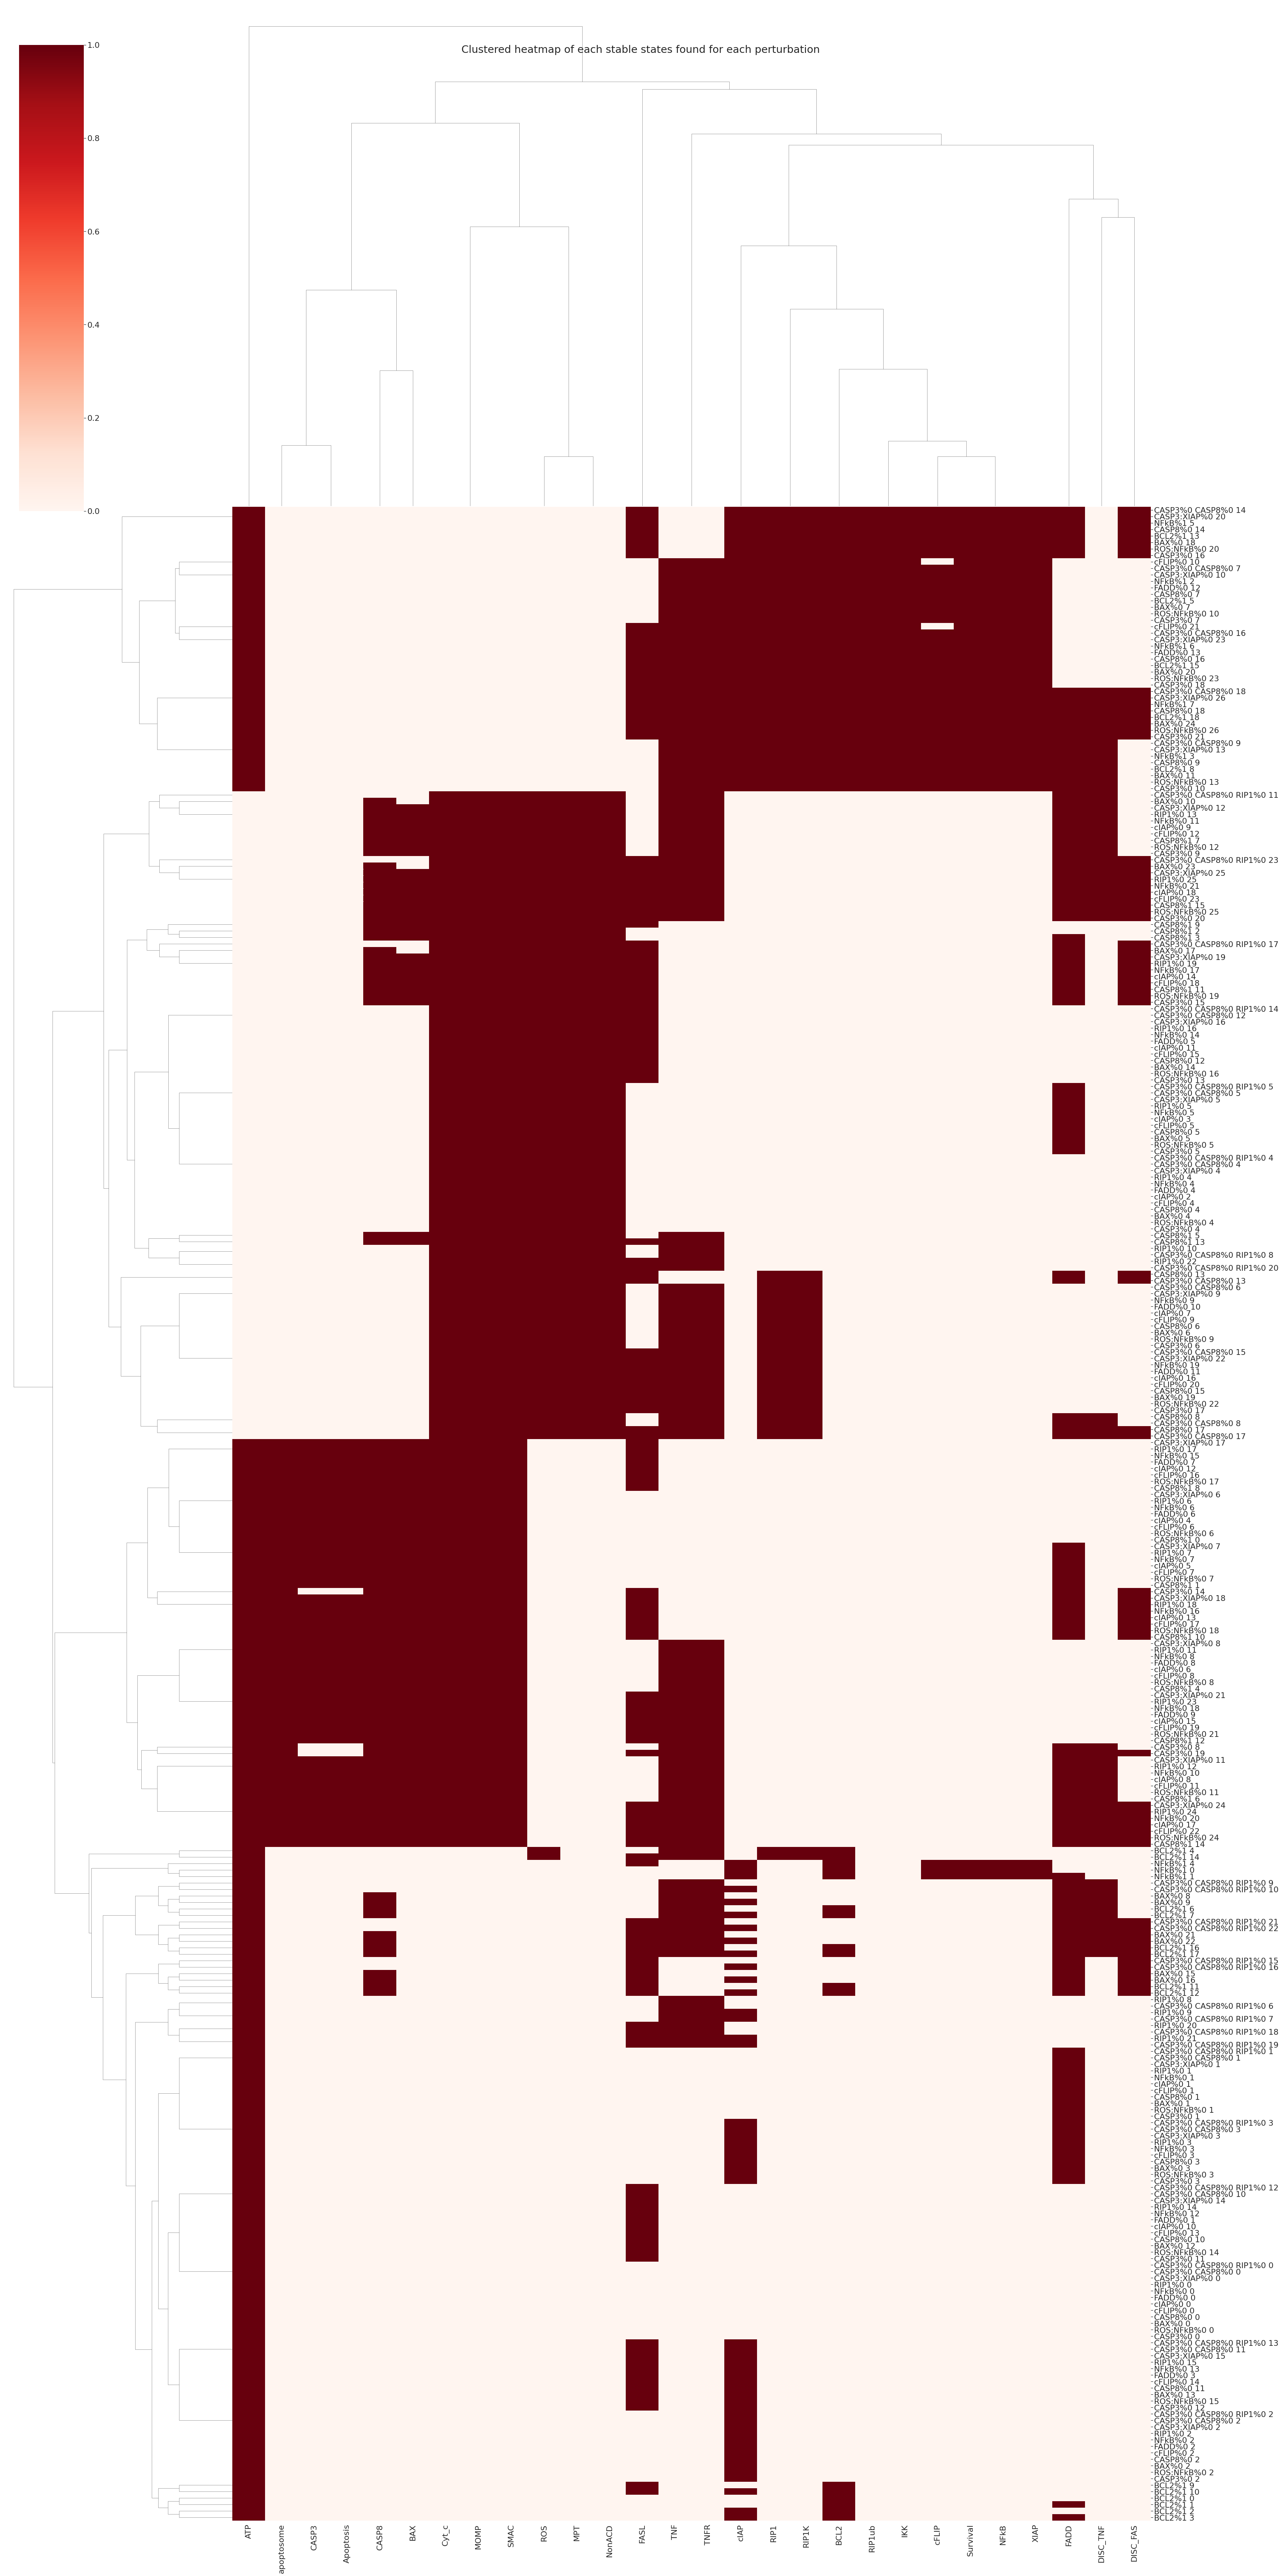

In [15]:
perturbations = ["ROS:NFkB%0",
                 "CASP3%0", 
                 "BAX%0",
                 "BCL2%1",
                 "CASP8%0", 
                 "CASP8%1", 
                 "cFLIP%0",
                 "cIAP%0",
                 "FADD%0", 
                 "NFkB%0",
                 "NFkB%1", 
                 "RIP1%0", 
                 "CASP3:XIAP%0",
                 "CASP3%0 CASP8%0",
                 "CASP3%0 CASP8%0 RIP1%0"
                ]


# Define dictionaries to store attractors for each perturbation
fixpointlist = {}


for p in perturbations:
    fixpoints = biolqm.fixpoints(biolqm.perturbation(model_biolqm, p))
    if(fixpoints):
        fixpointlist[p] = fixpoints


# List of perturbations with the nb of stable states 
perturbstates=[]

# List of table state values same order as perturbStates
stablestates = [] 

#List of nodes
nodelist = ['FASL', 'TNF', 'TNFR', 'DISC_TNF', 'DISC_FAS', 'FADD', 'RIP1', 'RIP1ub', 'RIP1K', 'IKK', 'NFkB', 'CASP8', 'BAX', 'BCL2', 'ROS', 'ATP', 'MPT', 'MOMP', 'SMAC', 'cIAP', 'Cyt_c', 'XIAP', 'apoptosome', 'CASP3', 'cFLIP', 'NonACD', 'Apoptosis', 'Survival']

for k,v in fixpointlist.items():   
    for i in range(0,len(v)):
        listSS = []
        for key, val in v[i].items():
            listSS.append(val)
        stablestates.append(listSS)
        perturbstates.append(str(k)+' '+str(i))

# Create dataframe: columns = nodes, rows = perturbations
df = pd.DataFrame(data=stablestates)
df.columns = nodelist
df.index = perturbstates

# Generate clustered heatmap
sns.set(font_scale=2)
cm = sns.clustermap(df, metric='euclidean', cmap = 'Reds', yticklabels=True, figsize=(50, 100))
cm.fig.suptitle('Clustered heatmap of each stable states found for each perturbation')
sns.set(font_scale=2)

This heatmap can be quite challenging to interpret, however, there are some interesting aspects to point out. 

For example, several mutations only end up in ATP being 1, with everything else turned off. NonACD on the other hand is 0 for most mutations, with the exception of a few others.

It also seems as if there are multiple clusters, that f.ex. when BAX is 0 for a mutation a few other nodes, such as CASP8, MOMP and Cyt_c (among a few others) are also 0. 
Especially MOMP and Cyt_c seem to be connected with each other, as they show the same behavior throughout all mutations. 

## MaBoSS simulation with pie charts and trajectory plots

In this section, we will calculate whether the final states ```Survival```, ```NonACD``` and ```Apoptosis``` can be reached when starting from a specific set of initial states using the MaBoSS formalism. 

First, the initial states have to be chosen. Then through a random Markov process, the system can be simulated and its trajectories can be analyzed. 

{'ROS:NFkB%0': <maboss.simulation.Simulation object at 0x7f112cbfc520>, 'CASP3%0': <maboss.simulation.Simulation object at 0x7f1142eb4370>, 'BAX%0': <maboss.simulation.Simulation object at 0x7f11347765e0>, 'BCL2%1': <maboss.simulation.Simulation object at 0x7f11430ffdc0>, 'CASP8%0': <maboss.simulation.Simulation object at 0x7f112ca94610>, 'CASP8%1': <maboss.simulation.Simulation object at 0x7f112c7353d0>, 'cFLIP%0': <maboss.simulation.Simulation object at 0x7f112c78c160>, 'cIAP%0': <maboss.simulation.Simulation object at 0x7f112c93bc70>, 'FADD%0': <maboss.simulation.Simulation object at 0x7f1142f3d3a0>, 'NFkB%0': <maboss.simulation.Simulation object at 0x7f112c7e4e20>, 'NFkB%1': <maboss.simulation.Simulation object at 0x7f112c76e100>, 'RIP1%0': <maboss.simulation.Simulation object at 0x7f113471c490>, 'CASP3:XIAP%0': <maboss.simulation.Simulation object at 0x7f1134716af0>, 'CASP3%0 CASP8%0': <maboss.simulation.Simulation object at 0x7f112c93fcd0>}


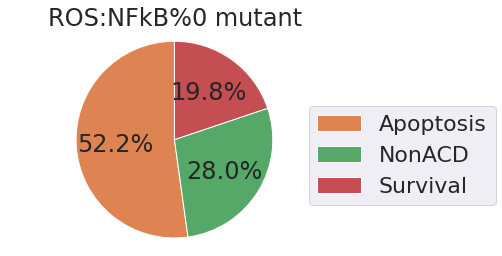

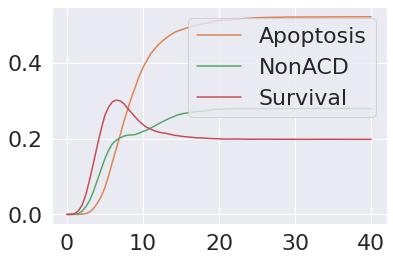

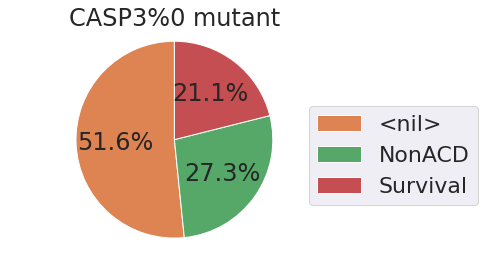

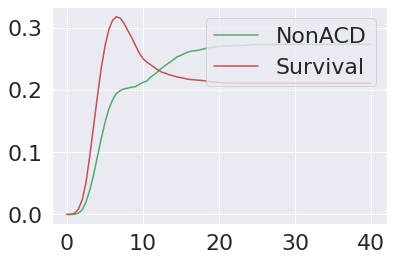

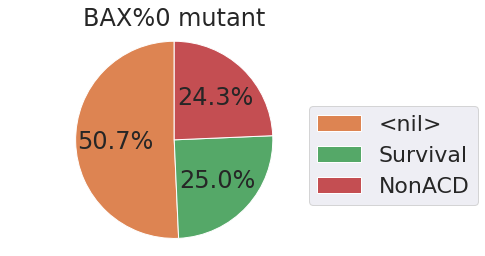

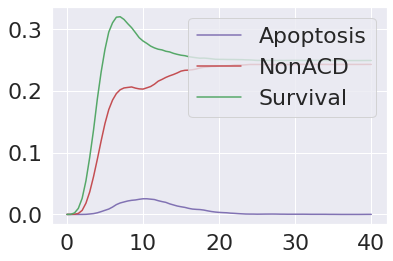

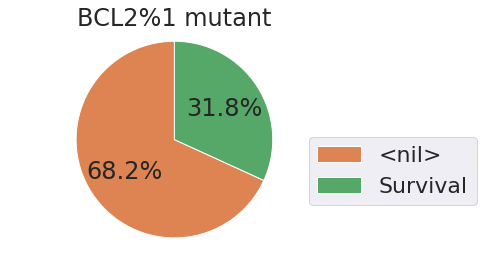

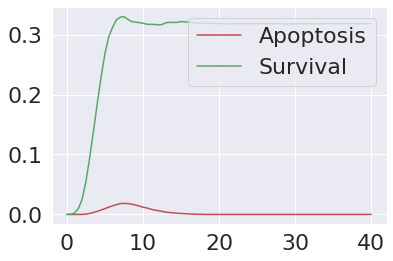

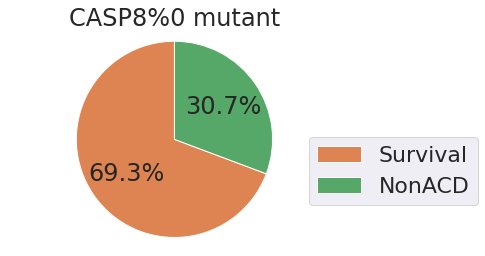

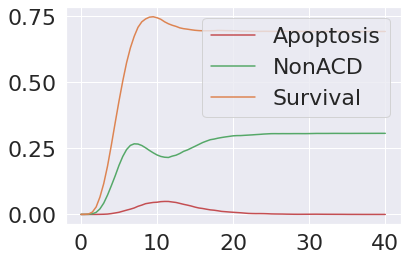

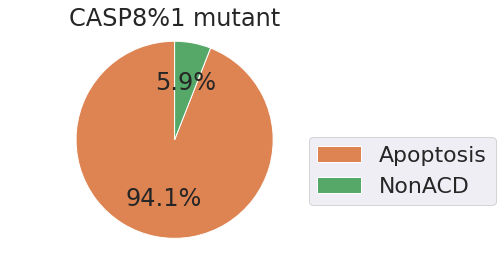

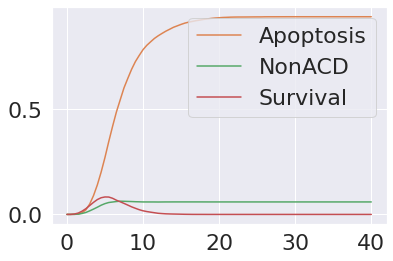

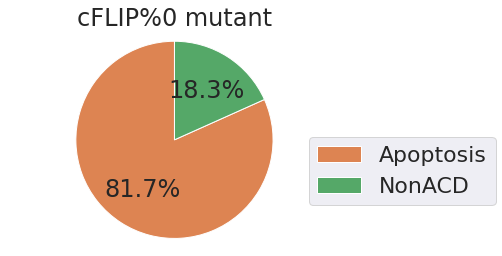

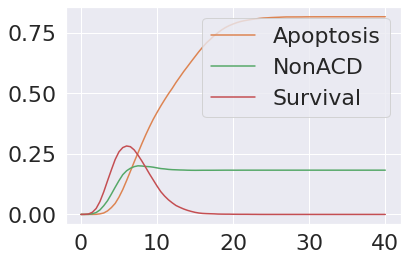

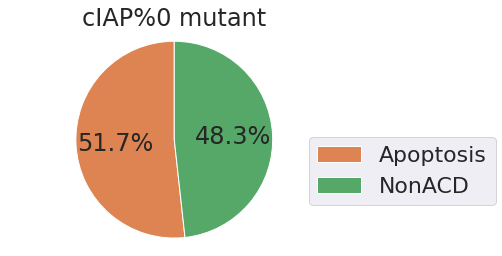

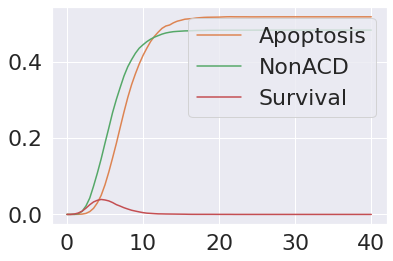

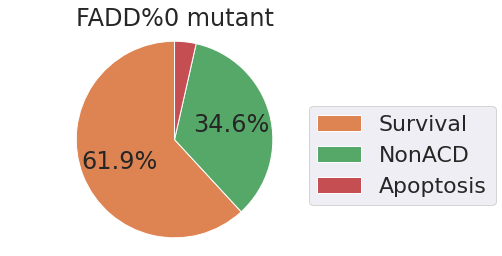

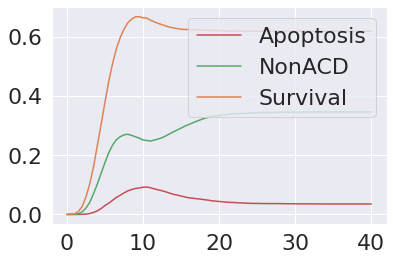

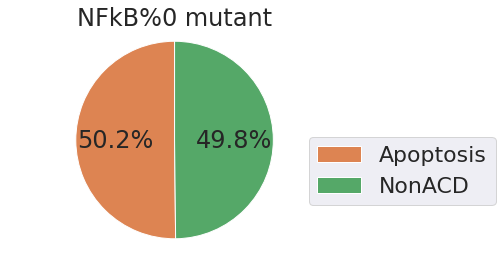

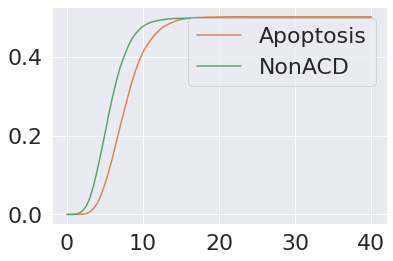

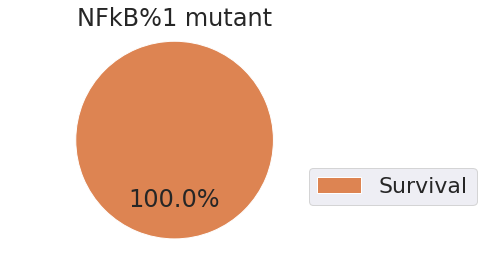

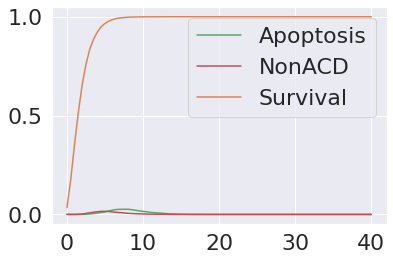

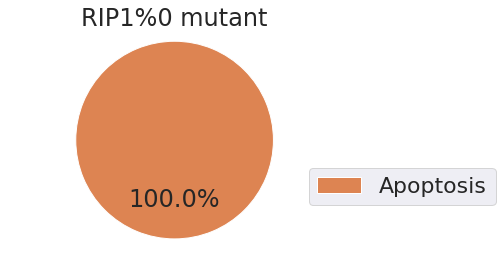

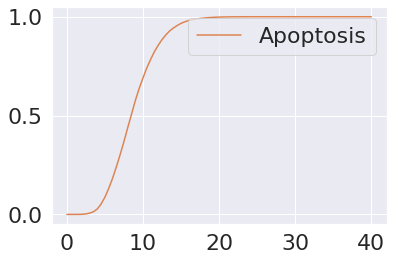

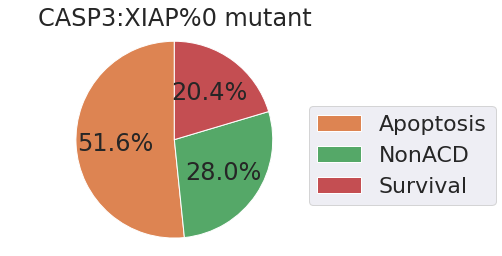

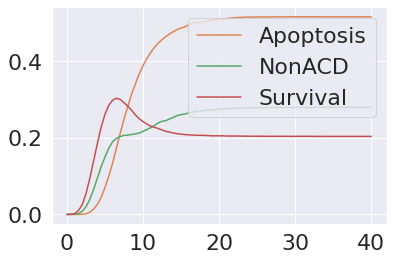

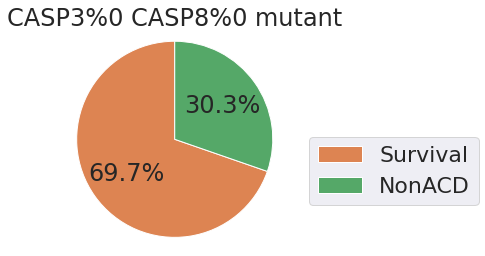

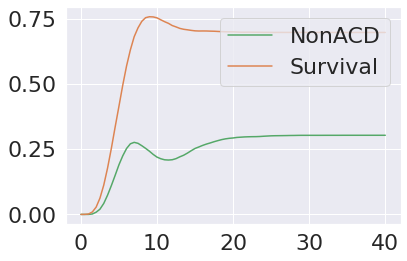

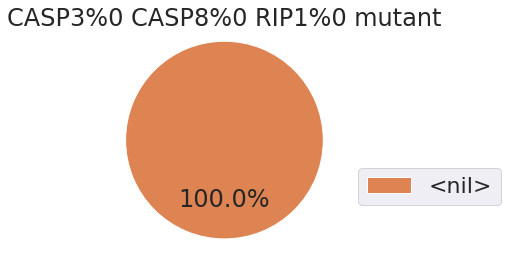

In [16]:
#import matplotlib.pyplot as plt
perturbations = ["ROS:NFkB%0",
                 "CASP3%0", 
                 "BAX%0",
                 "BCL2%1",
                 "CASP8%0", 
                 "CASP8%1", 
                 "cFLIP%0",
                 "cIAP%0",
                 "FADD%0", 
                 "NFkB%0",
                 "NFkB%1", 
                 "RIP1%0", 
                 "CASP3:XIAP%0",
                 "CASP3%0 CASP8%0",
                 #"CASP3%0 CASP8%0 RIP1%0"
                ]

# Define dictionaries to store attractors for each perturbation
fixpointlist = {}

for p in perturbations:
    fixpoints = biolqm.fixpoints(biolqm.perturbation(model_biolqm, p))
    if(fixpoints):
        fixpointlist[p] = fixpoints

'''
# uncomment to see attractors in tabulated tables for each perturbation
for k, v in fixpointlist.items():
    print(k)
    sys.displayhook(tabulate(v))
    print()
'''
# list to store perturbed models
mut_biolqm_list = {}
mut_maboss_list = {}


for p in perturbations:
    mut_maboss = biolqm.to_maboss(biolqm.perturbation(model_biolqm, p))
    mut_maboss.network.set_output(('Apoptosis','Survival','NonACD'))    
    maboss.set_nodes_istate(mut_maboss, ["ATP", "cIAP", "FADD"], [0,1])
    mut_maboss.network.set_istate('TNF', [0,1])
    mut_maboss.network.set_istate('FASL', [1,0])

   # mut_biolqm_list[p]=mut_biolqm
    mut_maboss_list[p] = mut_maboss
print(mut_maboss_list)


for p in mut_maboss_list:
    result = mut_maboss_list[p].run()
    result.plot_piechart()
    name = p
    plt.title("%s mutant" % name)
    if (result):
        result.plot_node_trajectory(until=40)
        
        
#here we perform the last pie chart in the paper, TNF=1, FAS=0, mutation---CASP3, CASP8 inhibitor and RIP1 deletion.    
perturbations = ["CASP3%0 CASP8%0 RIP1%0"]
fixpointlist = {}

for p in perturbations:
    fixpoints = biolqm.fixpoints(biolqm.perturbation(model_biolqm, p))
    if(fixpoints):
        fixpointlist[p] = fixpoints

mut_biolqm_list = {}
mut_maboss_list = {}

for p in perturbations:
    mut_maboss = biolqm.to_maboss(biolqm.perturbation(model_biolqm, p))
    mut_maboss.network.set_output(('Apoptosis','Survival','NonACD'))    
    maboss.set_nodes_istate(mut_maboss, ["ATP", "cIAP", "FADD"], [0,1])
    mut_maboss.network.set_istate('TNF', [0,1])
    mut_maboss.network.set_istate('FASL', [1,0])
    mut_maboss.network.set_istate('CASP3', [1,0])
    mut_maboss.network.set_istate('CASP8', [1,0])
    mut_maboss.network.set_istate('RIP1', [1,0])
    
   # mut_biolqm_list[p]=mut_biolqm
    mut_maboss_list[p] = mut_maboss

for p in mut_maboss_list:
    result = mut_maboss_list[p].run()
    result.plot_piechart()
    name = p
    plt.title("%s mutant" % name)

Interestingly, most of these mutations lead to a large increase in apoptosis. Except for a few mutations, almost all end up with more than 50% apoptosis, with the RIP1 deletion ending in 100% apoptosis.

However, it is quite obvious that all perturbation shown here have quite a big effect on the system, with all simulations showing differences to the wildtype. Many end up with only 2 states, for example the NFkB deletion or the CASP8 deletion. 

# Double mutation prediction, new insight explored

## Pint, formal mutation prediction (method: oneshot_mutations_for_cut)

Starting from the goal reachability identification purpose, we use Pint to formally predict the mutations that prevent cell fate ```Survival``` and ```NonACD```, thus these two cell states can not be reached. 

And we hope to identify the mutation type that leads to ```Apoptosis```, which could be the potential drug targets that trigger apoptosis in cancer cells.

Initial condition settings remain the same with TNF=1, FAS=0.

In [17]:
#TNF=1, FAS=0
#pint

goal = Goal("NonACD=1") | Goal("Survival=1")

model_pint.initial_state["TNF"] = 1
model_pint.initial_state["FASL"] = 0
model_pint.initial_state["FADD"] = 1
model_pint.initial_state["ATP"] = 1
model_pint.initial_state["cIAP"] = 1

mutations = model_pint.oneshot_mutations_for_cut(goal, maxsize=1, exclude={"TNF","FASL", "FADD"})
mutations


This computation is an *under-approximation*: returned mutations are all valid, but they may be non-minimal, and some solutions may be missed.

Limiting solutions to mutations of at most 1 automata. Use `maxsize` argument to change.

[{'TNFR': 0}, {'RIP1': 0}, {'CASP8': 1}]

First, we tested single mutation prediction and the results above in ```Out[17]``` give reasonable output. Together with the regulatory graph of our model, TNFR OFF means no activation of the downstream node RIP1, both involved in Survival pathway and NonACD pathway, thus prevent reaching the cell fate ```Survival``` and ```NonACD```. Besides, CASP8 is predicted to be ON since it plays a critical role in the activation of the Caspase-dependent apoptosis phenotype.

Then, we manipulate the parameter ```maxsize```= 2 to get double mutations, shown in ```Out[18]```.

In [18]:
#maxsize manipulation

mutations2 = model_pint.oneshot_mutations_for_cut(goal, maxsize=2, exclude={"TNF","FASL", "FADD"})
mutations2

This computation is an *under-approximation*: returned mutations are all valid, but they may be non-minimal, and some solutions may be missed.

Limiting solutions to mutations of at most 2 automata. Use `maxsize` argument to change.

[{'TNFR': 0},
 {'RIP1': 0},
 {'CASP8': 1},
 {'RIP1ub': 0, 'RIP1K': 0},
 {'RIP1ub': 0, 'BCL2': 1},
 {'RIP1ub': 0, 'ROS': 0},
 {'RIP1ub': 0, 'ATP': 1},
 {'RIP1ub': 0, 'MPT': 0},
 {'RIP1K': 0, 'IKK': 0},
 {'RIP1K': 0, 'NFkB': 0},
 {'RIP1K': 0, 'cIAP': 0},
 {'RIP1K': 0, 'CASP3': 1},
 {'IKK': 0, 'BCL2': 1},
 {'IKK': 0, 'ROS': 0},
 {'IKK': 0, 'ATP': 1},
 {'IKK': 0, 'MPT': 0},
 {'NFkB': 0, 'BCL2': 1},
 {'NFkB': 0, 'ROS': 0},
 {'NFkB': 0, 'ATP': 1},
 {'NFkB': 0, 'MPT': 0},
 {'BCL2': 1, 'cIAP': 0},
 {'BCL2': 1, 'CASP3': 1},
 {'ROS': 0, 'cIAP': 0},
 {'ROS': 0, 'CASP3': 1},
 {'ATP': 1, 'cIAP': 0},
 {'ATP': 1, 'CASP3': 1},
 {'MPT': 0, 'cIAP': 0},
 {'MPT': 0, 'CASP3': 1}]

Several double mutations returned and some of them could be of interest for further testing.

Here we choose one mutation combination ```'NFkB': 0, 'MPT': 0``` and verify the reachability using the **lock** method in Pint. Given the goal we set beforehand, this mutation combination is prevented from reaching the goal, that is cell fate ```Survival``` and ```NonACD```. 

Then a FALSE result is expected, shown in ```Out[19]```.

In [19]:
#goal = Goal("NonACD=1") | Goal("Survival=1")
model_pint.lock({'NFkB': 0, 'MPT': 0}).reachability(goal)

False

Besides, we repeat the reachability checking by setting the goal as ```Apoptosis```, this time a TRUE result tells us that this double mutation can reach apoptosis.

In [20]:
# test whether this double mutation can reach apoptosis
model_pint.lock({'NFkB': 0, 'MPT': 0}).reachability("Apoptosis=1")

True

## Pint, assessing mutations that can prevent reachability (method: cutsets)

In the last section, we found that double mutation ```'NFkB': 0, 'MPT': 0``` can not reach ```Survival``` and ```NonACD```, but can reach ```Apoptosis```.

In this section, we will use another method in Pint to further confirm it on a contrary aspect. 

Analyzing the cut sets can identify mutations that hinder the system to reach a given state. Here we chose ```Survival``` and ```NonACD```. These are sets of states which cover all paths from the initial state to any state where the goal is on. 

By disabling these cut sets, the paths to the goal are removed and thus the reachability should be zero.

In [21]:
# setting the initial state with TNF on.
model_pint_TNF_on = model_pint.having({"TNF": 1, "FASL": 0, "cIAP": 1, "ATP": 1, "FADD": 1})
model_pint_TNF_on.initial_state.nonzeros() # shows the inital states that have a value other than 0

{'TNF': 1, 'FADD': 1, 'ATP': 1, 'cIAP': 1}

In [22]:
# Predict which mutations will hinder the system from reaching Apoptosis using Pint
goal = Goal("NonACD=1") | Goal("Survival=1")
model_pint_TNF_on.cutsets(goal, maxsize=3, exclude={"TNF","FASL","FADD"}) 

This computation is an *under-approximation*: returned cut-sets are all valid, but they may be non-minimal, and some cut-sets may be missed.

Limiting results to cut-sets with at most 3 elements. Use `maxsize` argument to change.

[{'TNFR': 1},
 {'RIP1': 1},
 {'CASP8': 0},
 {'_pint_goal': 1},
 {'RIP1ub': 1, 'RIP1K': 1},
 {'RIP1ub': 1, 'NFkB': 0},
 {'RIP1ub': 1, 'BCL2': 0},
 {'RIP1ub': 1, 'ROS': 1},
 {'RIP1ub': 1, 'ATP': 0},
 {'RIP1ub': 1, 'MPT': 1},
 {'RIP1K': 1, 'IKK': 1},
 {'RIP1K': 1, 'NFkB': 1},
 {'RIP1K': 1, 'cIAP': 1},
 {'RIP1K': 1, 'CASP3': 0},
 {'IKK': 1, 'NFkB': 0},
 {'IKK': 1, 'BCL2': 0},
 {'IKK': 1, 'ROS': 1},
 {'IKK': 1, 'ATP': 0},
 {'IKK': 1, 'MPT': 1},
 {'NFkB': [0, 1]},
 {'NFkB': 0, 'cIAP': 1},
 {'NFkB': 0, 'CASP3': 0},
 {'NFkB': 1, 'BCL2': 0},
 {'NFkB': 1, 'ROS': 1},
 {'NFkB': 1, 'ATP': 0},
 {'NFkB': 1, 'MPT': 1},
 {'BCL2': 0, 'cIAP': 1},
 {'BCL2': 0, 'CASP3': 0},
 {'ROS': 1, 'cIAP': 1},
 {'ROS': 1, 'CASP3': 0},
 {'ATP': 0, 'cIAP': 1},
 {'ATP': 0, 'CASP3': 0},
 {'MPT': 1, 'cIAP': 1},
 {'MPT': 1, 'CASP3': 0}]

Interestingly, most of these cut sets contain many of the same nodes, especially NFkB and RIP1 seem to be involved in a majority of the cut sets, thus implying that they are important regulatory nodes. This is reasonable since we have "NFkB activated survival" and "RIP1 dependent necrosis".

In the results we found a double mutation {'NFkB': 1, 'MPT': 1}, which can be the cut sets. This is what we expect to have since the disable of this cut sets is equal to the double mutation tested in the last section.

Thus, we **disable** ```'NFkB': 1, 'MPT': 1```, which means the double mutation ```'NFkB': 0, 'MPT': 0```, and check the phenotype reachability. As expected, this double mutation type can not reach ```Survival``` and ```NonACD``` so a FALSE returned in ```Out[23]```.

At the same time, the reachability of ```Apoptosis``` returned TRUE, further confirmed our hypothesis.

In [23]:
# Calculating the reachability of goal after applying a cut set to hinder reachability. 
#goal = Goal("NonACD=1") | Goal("Survival=1")
model_pint_TNF_on.disable(NFkB=1,MPT=1).reachability(goal)

False

In [24]:
# Calculating the reachability of Apoptosis
model_pint_TNF_on.disable(NFkB=1,MPT=1).reachability("Apoptosis=1")

True

## MaBoSS, confirm double mutation simulation result from Pint

The double mutation ```'NFkB': 0, 'MPT': 0``` is tested as not able to reach cell fate ```Survival``` nor ```NonACD```, but ```Apoptosis```. Then, can a meaningful result backup this *in silico* observation be reproduced using another tool such as MaBoSS?

We performed the mutation simulation analysis, with double mutation ```'NFkB': 0, 'MPT': 0```, finding that ```Apoptosis``` is the outcome and no other phenotype reached. This aligned with the result from Pint, the double mutation won't lead to ```Survival``` nor ```NonACD```.

What's more, this double mutation can reach ```Apoptosis``` at 100%, indicating potential treatment that could lead to programmed cell death in cancer tissues.


This part is tested under the same initial condition TNF=1, FAS=0.

{'FASL': 0, 'TNF': 1, 'TNFR': 0, 'DISC_TNF': 0, 'DISC_FAS': 0, 'FADD': 1, 'RIP1': 0, 'RIP1ub': 0, 'RIP1K': 0, 'IKK': 0, 'NFkB': 0, 'CASP8': 0, 'BAX': 0, 'BCL2': 0, 'ROS': 0, 'ATP': 1, 'MPT': 0, 'MOMP': 0, 'SMAC': 0, 'cIAP': 1, 'Cyt_c': 0, 'XIAP': 0, 'apoptosome': 0, 'CASP3': 0, 'cFLIP': 0, 'NonACD': 0, 'Apoptosis': 0, 'Survival': 0}


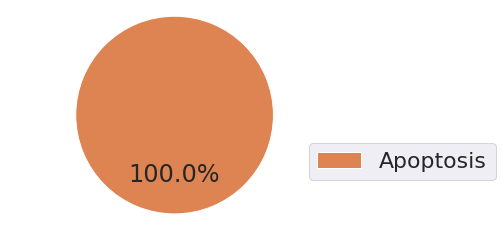

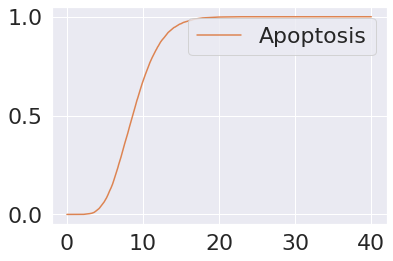

In [25]:
# test TNF=1, FAS=0
# double mutation
# maboss

maboss_doublemutation = model_maboss.copy()
maboss.set_nodes_istate(maboss_doublemutation, ["ATP", "cIAP", "FADD", "TNF"], [0,1])
maboss.set_nodes_istate(maboss_doublemutation, ["FASL"], [1,0])
print(maboss_doublemutation.get_initial_state())

#'NFkB': 0, 'MPT': 0
maboss_doublemutation.mutate('NFkB', 'OFF')
maboss_doublemutation.mutate('MPT', 'OFF')


# Perform the simulation
result = maboss_doublemutation.run()
result.plot_piechart()
result.plot_node_trajectory(until=40)

# The Reduced Model

## Model reduction, importation, visualization

In order to simplify the model, we reduced it using GINsim model reduction functionality.

However, compared with the manually reduced model in the paper, we found a slightly different point, that is, an additional inhibition sign from ```NFkB``` to ```CASP3``` exist in the manually reduced model but not the GINsim reduced model.

This could be explained by the principle that model reduction will preserve the dynamical properties.


In [26]:
#load the reduced model

lrg = ginsim.load("https://raw.githubusercontent.com/yitong-sun/BI8040_2020/master/Reduced_model.zginml")

# show the model
ginsim.show(lrg)

Downloading https://raw.githubusercontent.com/yitong-sun/BI8040_2020/master/Reduced_model.zginml

## Attractor analysis, fixpoint display

In [27]:
lqm = ginsim.to_biolqm(lrg)
# Calculate the fixpoints and show them
pert = biolqm.perturbation(lqm, "FADD%1")
fps = biolqm.fixpoints(pert)
print(len(fps), "fixpoints")
tabulate(fps)

13 fixpoints


,FASL,TNF,FADD,RIP1,NFkB,CASP8,ROS,ATP,MPT,MOMP,cIAP,CASP3,NonACD,Apoptosis,Survival
0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0
3,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0
4,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0
5,0,1,1,0,0,1,1,0,1,1,0,0,1,0,0
6,0,1,1,1,1,0,0,1,0,0,1,0,0,0,1
7,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0
9,1,0,1,0,0,1,1,0,1,1,0,0,1,0,0
11,1,0,1,1,1,0,0,1,0,0,1,0,0,0,1


In [28]:
ginsim.show(lrg, fps[11])

## Analysis of the reduced model with MaBoSS

Wild-type model analyses, first set the initial state TNF=0, FAS=0, getting the naive state as the same in the master model.

Then with TNF=1, FAS=0, getting all three cell fate reachable, which also similar to that of the master model.

{'FASL': 0, 'TNF': 0, 'TNFR': 0, 'DISC_TNF': 0, 'DISC_FAS': 0, 'FADD': 1, 'RIP1': 0, 'RIP1ub': 0, 'RIP1K': 0, 'IKK': 0, 'NFkB': 0, 'CASP8': 0, 'BAX': 0, 'BCL2': 0, 'ROS': 0, 'ATP': 1, 'MPT': 0, 'MOMP': 0, 'SMAC': 0, 'cIAP': 1, 'Cyt_c': 0, 'XIAP': 0, 'apoptosome': 0, 'CASP3': 0, 'cFLIP': 0, 'NonACD': 0, 'Apoptosis': 0, 'Survival': 0}


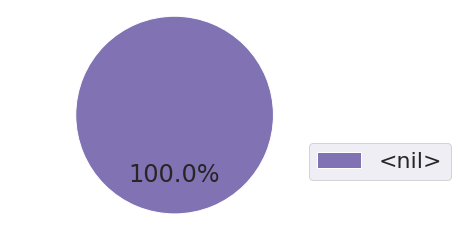

In [29]:
#model_maboss = biolqm.to_maboss(lqm)

model_maboss.update_parameters(discrete_time=0, use_physrandgen=0,
        seed_pseudorandom=100, sample_count=10000,
        max_time=75, time_tick=0.1, thread_count=4,
        statdist_traj_count=100, statdist_cluster_threshold=0.9)

#maboss.wg_set_output(model_maboss)
#maboss.set_output(model_maboss, ["NonACD","Survival", "Apoptosis"])
model_maboss.network.set_output(('Apoptosis','Survival','NonACD'))


## choosing the initial states
# model the different wildtypes (one with TNF=FAS=0 and one with TNF=1 and FAS=0)
maboss_1 = model_maboss.copy()
maboss.set_nodes_istate(maboss_1, ["ATP", "cIAP", "FADD"], [0,1])
maboss.set_nodes_istate(maboss_1, ["TNF", "FASL"], [1,0])

print(maboss_1.get_initial_state())

# Perform the simulation
result = maboss_1.run()
result.plot_piechart()
#result.plot_node_trajectory(until=40)

{'FASL': 0, 'TNF': 1, 'TNFR': 0, 'DISC_TNF': 0, 'DISC_FAS': 0, 'FADD': 1, 'RIP1': 0, 'RIP1ub': 0, 'RIP1K': 0, 'IKK': 0, 'NFkB': 0, 'CASP8': 0, 'BAX': 0, 'BCL2': 0, 'ROS': 0, 'ATP': 1, 'MPT': 0, 'MOMP': 0, 'SMAC': 0, 'cIAP': 1, 'Cyt_c': 0, 'XIAP': 0, 'apoptosome': 0, 'CASP3': 0, 'cFLIP': 0, 'NonACD': 0, 'Apoptosis': 0, 'Survival': 0}


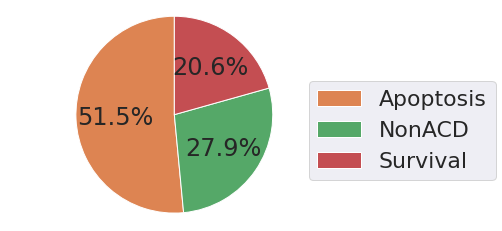

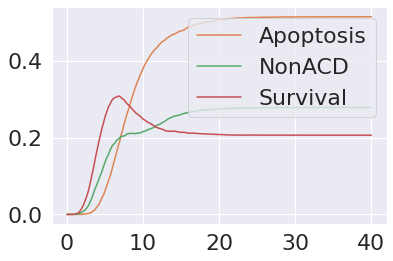

In [30]:
# test TNF=1, FAS=0, wildtype

maboss_2 = model_maboss.copy()
maboss.set_nodes_istate(maboss_2, ["ATP", "cIAP", "FADD", "TNF"], [0,1])
maboss.set_nodes_istate(maboss_2, ["FASL"], [1,0])
print(maboss_2.get_initial_state())

# Perform the simulation
result = maboss_2.run()
result.plot_piechart()
result.plot_node_trajectory(until=40)

## Conclusion:

- In this project, first we reproduce the results from the literature of a cell fate decision model using different software tools under various experimental conditions.

    - For the **master model**, interestingly, we managed to reproduce ALL the phenotype reachability analysis results using the stochastic simulation tool MaBoSS, which is developed after the publication of this paper. This comparison of that different tools leading to the replicative results indicates a bright reproducible science prospect on this model.
    
    - For the **reduced model**, there is a slight difference of an inhibition sign NFkB -|CASP3 that exists in the manually reduced model in the paper but not the GINsim reduced model. We check the dynamical behavior of the two versions of the reduced model, and found similar model properties in attractors and reachability. Thus we decided to present the GINsim reduced model in this notebook.
    
    
- Besides, we also test a pair of double mutation predicted *in silico* on the master model, which can be an example of shading light to real experiment design. Using Pint, the double mutation```'NFkB': 0, 'MPT': 0``` was predicted to prevent reaching ```Survival``` and ```NonACD```, later we confirmed that it can lead to ```Apoptosis``` in MaBoSS simulation, which could be a potential target to get cancer cells to enter apoptosis.


- In short, it is apparent that there are some nodes in the system that are crucial in the decision whether a cell will enter ```Apoptosis```, ```NonACD``` or continue ```Survival```. This logical model has made it clear how these nodes affect the behavior and thus has increased the understanding of this decision. 


### Future steps

There are still some aspects of this model that are worth investigating, for example
- Study cross-talks between these pathways.
- Model extension by manual curation and omics data analysis, then study the model dynamical behavior.
- Test model performance in different cell lines, which can be compared qualitatively to experimental results available in the literature.